# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install opencv-python
!pip install matplotlib
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Data import

**import data and get labels**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **data generation for meniscus**

In [5]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
def data_gen(dataset_type,path, plane, diagnosis):
    '''this function gets the data from the extracted datset'''

    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform17d' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform17d' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'

    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


In [6]:
# generate training input
BASE_PATH = "/content/drive/My Drive/miniscus data set/MRNet-v1.0/"

coronal_mensicus, coronal_mensicus_label = data_gen('train',BASE_PATH, 'coronal/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train',BASE_PATH, 'sagittal/extracted_images', 'meniscus')
print(sagittal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid',BASE_PATH, 'coronal/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid',BASE_PATH, 'sagittal/extracted_images', 'meniscus')

print(coronal_mensicus_val.shape)

(1130, 17, 256, 256)
(120, 17, 256, 256)


In [7]:
 # Assuming axial_mensicus, coronal_mensicus, and sagittal_mensicus are your input arrays
# Reshape your data to add the channel dimension
coronal_mensicus = coronal_mensicus.reshape(-1, IMAGE_DEPTH, IMAGE_SIZE, IMAGE_SIZE)
sagittal_mensicus = sagittal_mensicus.reshape(-1, IMAGE_DEPTH, IMAGE_SIZE, IMAGE_SIZE)
coronal_mensicus_val = coronal_mensicus_val.reshape(-1, IMAGE_DEPTH, IMAGE_SIZE, IMAGE_SIZE)
sagittal_mensicus_val = sagittal_mensicus_val.reshape(-1, IMAGE_DEPTH, IMAGE_SIZE, IMAGE_SIZE)


In [8]:
# Assuming mensicus_label is initially a list, convert it to a NumPy array
coronal_mensicus_label = np.array(coronal_mensicus_label)
sagittal_mensicus_label = np.array(sagittal_mensicus_label)


In [9]:

from sklearn.metrics import log_loss
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Transfer Learning

##  Hyperparameters

In [3]:
# Define your parameters
IMAGE_SIZE= 256  # Adjust based on your actual image dimensions
IMAGE_DEPTH = 17
NUM_CLASSES = 1
CHANNELS = 1

batch_size = 32
nb_epoch = 50
dropout = 0.4
lr = 5e-4 # Learning rate

## Model Creation and training

In [10]:
# Convert input data to float32 and print shapes to check
coronal_mensicus = np.transpose(coronal_mensicus, (0, 2, 3, 1)).astype('float32')
sagittal_mensicus = np.transpose(sagittal_mensicus, (0, 2, 3, 1)).astype('float32')
coronal_mensicus_val = np.transpose(coronal_mensicus_val, (0, 2, 3, 1)).astype('float32')
sagittal_mensicus_val = np.transpose(sagittal_mensicus_val, (0, 2, 3, 1)).astype('float32')

In [11]:
# Ensure that coronal_mensicus and sagittal_mensicus are NumPy arrays
coronal_mensicus = np.asarray(coronal_mensicus)
sagittal_mensicus = np.asarray(sagittal_mensicus)
coronal_mensicus_val = np.asarray(coronal_mensicus_val)
sagittal_mensicus_val = np.asarray(sagittal_mensicus_val)

# Labels should also be NumPy arrays
coronal_mensicus_label = np.asarray(coronal_mensicus_label)
coronal_mensicus_label_val = np.asarray(coronal_mensicus_label_val)

# Check shapes to ensure they're correct
print(coronal_mensicus.shape)  # Should be (num_samples, 256, 256, 17)
print(sagittal_mensicus.shape)  # Should be (num_samples, 256, 256, 17)
print(coronal_mensicus_val.shape)
print(sagittal_mensicus_val.shape)
print(coronal_mensicus_label.shape)

(1130, 256, 256, 17)
(1130, 256, 256, 17)
(120, 256, 256, 17)
(120, 256, 256, 17)
(1130,)


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling1D, Reshape, Conv2D
from tensorflow.keras.optimizers import SGD, schedules
from tensorflow.keras.callbacks import ModelCheckpoint
def create_model2(input_shape, NUM_CLASSES, dropout):


    # Define input for each plane
    input_coronal = Input(shape=input_shape, name='input_coronal')
    input_sagittal = Input(shape=input_shape, name='input_sagittal')

    # 1x1 Convolution to reduce depth from 17 to 1 for each plane
    # conv_axial = Conv2D(filters=1, kernel_size=(1, 1), activation='relu', padding='same')(input_axial)
    conv_coronal = Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same')(input_coronal)
    conv_sagittal = Conv2D(filters=3, kernel_size=(3, 3), activation='relu', padding='same')(input_sagittal)

    # Base DenseNet model for each plane (coronal, sagittal)
    base_model = DenseNet121(weights='imagenet', include_top=False, pooling=None, input_shape=(256,256,3))

    # Process each plane using the same base DenseNet model
    # axial_output = base_model(conv_axial)
    coronal_output = base_model(conv_coronal)
    sagittal_output = base_model(conv_sagittal)

    # Global Average Pooling for each plane
    # axial_output = GlobalAveragePooling2D()(axial_output)
    coronal_output = GlobalAveragePooling2D()(coronal_output)
    sagittal_output = GlobalAveragePooling2D()(sagittal_output)

    # Concatenate the outputs from all planes
    # concatenated = Concatenate()([axial_output, coronal_output, sagittal_output])
    concatenated = Concatenate()([coronal_output, sagittal_output])

    # Dense and Dropout layers after concatenation
    x = BatchNormalization()(concatenated)
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(512, activation='relu')(x)

    output = Dense(NUM_CLASSES, activation='sigmoid')(x)

    # Create the final model
    # model = Model(inputs=[input_axial, input_coronal, input_sagittal], outputs=output)
    model = Model(inputs=[input_coronal, input_sagittal], outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

if __name__ == '__main__':
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 17)
    model = create_model2(input_shape, NUM_CLASSES, dropout)
    #loss='binary_crossentropy'
    # Compile the model
    model.compile(optimizer=SGD(learning_rate=lr, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        # Set up the checkpoint
    filepath = "bestmodel.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # Train the model with axial, coronal, and sagittal planes
    history = model.fit([coronal_mensicus, sagittal_mensicus],
                        coronal_mensicus_label,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=([coronal_mensicus_val, sagittal_mensicus_val], coronal_mensicus_label_val),
                        callbacks=callbacks_list)




29084464/29084464 [==============================] - 0s 0us/step
Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 0.7306 - accuracy: 0.5788
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to bestmodel.keras
36/36 [==============================] - 194s 5s/step - loss: 0.7306 - accuracy: 0.5788 - val_loss: 0.7312 - val_accuracy: 0.5333
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.6133
Epoch 2: val_accuracy did not improve from 0.53333
36/36 [==============================] - 170s 5s/step - loss: 0.6989 - accuracy: 0.6133 - val_loss: 0.7020 - val_accuracy: 0.5167
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.6133
Epoch 3: val_accuracy improved from 0.53333 to 0.55000, saving model to bestmodel.keras
36/36 [==============================] - 168s 5s/step - loss: 0.6875 - accuracy: 0.6133 - val_loss: 0.6968 - val_accuracy: 0.5500
Epoch 4/50
36/36 [=====================

In [13]:
 # Evaluate the model
predictions_valid = model.predict([coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
score = log_loss(coronal_mensicus_label_val, predictions_valid)

print(f"Log Loss: {score}")
model.summary()

4/4 [==============================] - 7s 1s/step
Log Loss: 0.6864022907621987
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_coronal (InputLayer)  [(None, 256, 256, 17)]       0         []                            
                                                                                                  
 input_sagittal (InputLayer  [(None, 256, 256, 17)]       0         []                            
 )                                                                                                
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 3)          462       ['input_coronal[0][0]']       
                                                                                                  
 conv2d_1 (Conv

## Model evaluation

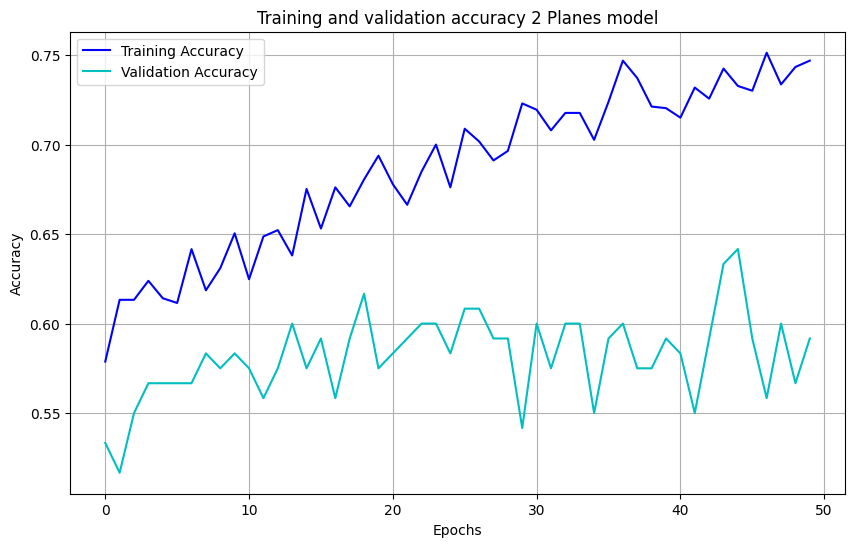

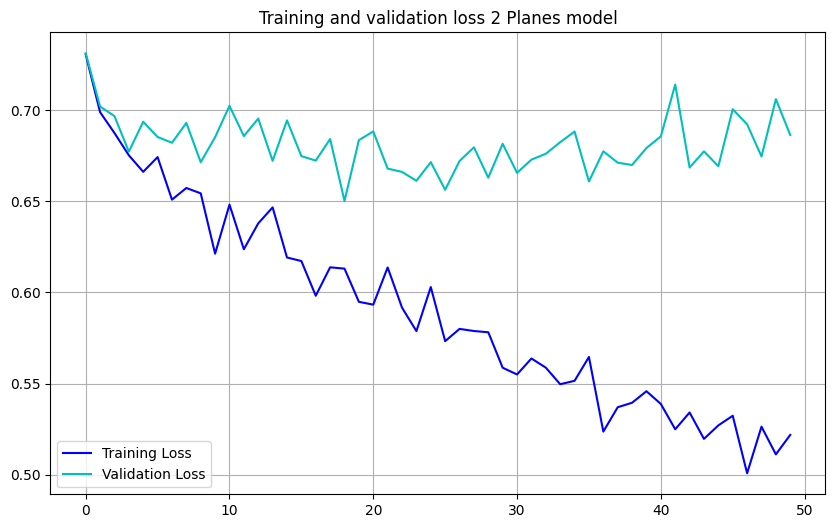

In [14]:
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'c',label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title(f'Training and validation accuracy 2 Planes model')
plt.grid(True)
plt.legend()
plt.savefig(f'Training and validation accuracy 2 Planes model.png')




#Plot training and validation loss per epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'c',label='Validation Loss')


plt.title(f'Training and validation loss 2 Planes model')
plt.savefig(f'Training and validation loss 2 Planes model.png')
plt.grid(True)
plt.legend()

plt.show()


In [15]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Threshold predictions: Convert probabilities to binary labels (0 or 1)
threshold = 0.5
predictions_valid_binary = (predictions_valid > threshold).astype(int)

# Calculate accuracy
acc = accuracy_score(coronal_mensicus_label_val, predictions_valid_binary)

# Optionally, calculate precision and recall
precision = precision_score(coronal_mensicus_label_val, predictions_valid_binary)

recall = recall_score(coronal_mensicus_label_val, predictions_valid_binary)

# Output the results
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.5916666666666667
Precision: 0.5348837209302325
Recall: 0.4423076923076923


In [16]:
model.save("3PlanesDenseModel.keras")
from google.colab import files
files.download('3PlanesDenseModel.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
files.download("Training and validation accuracy 2 Planes model.png")
files.download("Training and validation loss 2 Planes model.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>